# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

**Problema de Otimização de Logística de Entregas:**

O problema consiste em otimizar a logística de entregas no Distrito Federal, observando áreas com maiores demandas, distribuindo as entregas de forma mais eficiente entre as bases e compreendendo as características das entregas, incluindo tamanhos e destinos.

A logística eficiente visa reduzir custos operacionais, melhorar o atendimento ao cliente e maximizar o uso de recursos disponíveis. O aumento na atividade de entrega em algumas regiões pode resultar em desperdício de recursos, atrasos e desequilíbrio operacional. Além disso, é crucial compreender a variedade de tamanhos de entregas para otimizar a capacidade dos veículos utilizados.

Espera-se uma melhoria na eficiência das entregas, redução dos custos de transporte, diminuição dos atrasos nas entregas e garantia de atendimento às demandas da forma mais eficaz possível. Com a otimização geral, é possível alcançar resultados com economia de recursos, satisfação dos clientes e melhor desempenho nas operações.

## 2\. Pacotes e bibliotecas

In [ ]:
pip install geobr

In [ ]:
pip install descartes

In [ ]:
# Instalação de bibliotecas
import json
import geopy
import requests
import geopandas as gpd
import pandas as pd
import seaborn as sns
import numpy as np
import geobr
import matplotlib.pyplot as plt
import descartes

#Importação de funções específicas
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

## 3\. Exploração de dados

In [ ]:
url = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json' #Adicionando o link à variável
filename = 'entregas.json' #Atribuindo o nome do arquivo à variável
response = requests.get(url) #Adicionando o requests à uma variável
with open(filename, 'wb') as fp: #Criando o arquivo
    fp.write(response.content)# Escrevendo o conteúdo no arquivo

# Repetindo o processo para o arquivo CSV
url = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv'
filename = 'entregas-geodata.csv'
response = requests.get(url)
with open(filename, 'wb') as fp:
    fp.write(response.content)

entregas_json = pd.read_json('entregas.json')# Carregando o arquivo JSON em um DataFrame

entregas_geodata = pd.read_csv('entregas-geodata.csv', header = 0)# Carregando o arquivo CSV em outro DataFrame

entregas_df = pd.merge(left=entregas_json, right=entregas_geodata, how="inner", left_index=True, right_index=True)# Unindo os DataFrames com merge usando índices

# Normalizando a coluna "origin" e juntando com o DataFrame
origin_separacao_df = pd.json_normalize(entregas_df["origin"])
entregas_df = pd.merge(left=entregas_df, right=origin_separacao_df, how='inner', left_index=True, right_index=True)


entregas_df = entregas_df.drop(["origin", "delivery_lat", "delivery_lng"], axis=1)# Removendo colunas que não serão usadas
entregas_df = entregas_df.rename(columns={
    "name" : "Nome",
    "region" : "Regiao",
    "vehicle_capacity" : "Capacidade_veiculo",
    "deliveries" : "Entregas",
    "lng" : "Base_lng",
    "lat" : "Base_lat",
    "delivery_city" : "Cidade_entrega",
    "delivery_suburb" : "Regiao_entrega"
})# Renomeando colunas para melhor entendimento

entregas_df = entregas_df[["Nome", "Regiao", "Base_lng", "Base_lat", "Cidade_entrega", "Regiao_entrega", "Capacidade_veiculo", "Entregas"]]# Reorganizando as colunas


entregas_exploded_df = entregas_df[["Entregas"]].explode("Entregas")# Explodindo a coluna "Entregas"

entregas_normalizadas_df = pd.concat([
    pd.DataFrame(entregas_exploded_df["Entregas"].apply(lambda reorganizar: reorganizar["size"])).rename(columns={"Entregas" : "Tamanho_da_entrega"}),
    pd.DataFrame(entregas_exploded_df["Entregas"].apply(lambda reorganizar: reorganizar["point"]["lng"])).rename(columns={"Entregas": "Entrega_lng"}),
    pd.DataFrame(entregas_exploded_df["Entregas"].apply(lambda reorganizar: reorganizar["point"]["lat"])).rename(columns={"Entregas": "Entrega_lat"}),
], axis=1)# Criando um DataFrame com colunas normalizadas

# Juntando os DataFrames para a inclusão de colunas normalizadas e formatadas
entregas_df = entregas_df.drop("Entregas", axis=1)
entregas_df = pd.merge(left=entregas_df, right=entregas_normalizadas_df, how='right', left_index=True, right_index=True)
entregas_df.reset_index(inplace=True, drop=True)

entregas_df[["Cidade_entrega", "Regiao_entrega"]] = entregas_df[["Cidade_entrega", "Regiao_entrega"]].fillna("Sem_Informação.")# Preenchendo valores que podereiam estar como nulos

entregas_df.dtypes# Visualizando o tipo de dados nas colunas do DataFrame

entregas_df.select_dtypes("object").describe().transpose()# Formando uma melhor visualização das colunas do tipo objeto

visualizacao_entregas_df = entregas_df.drop(["Nome", "Regiao"], axis=1).select_dtypes('int64').describe().transpose()# Criando um DataFrame para visualização das estatísticas das colunas numéricas



In [ ]:
entregas_df.head() # Exibir as primeiras linhas do DataFrame 'entregas_df' para a visualização

In [ ]:
visualizacao_entregas_df.head()# Exibir as primeiras linhas do DataFrame 'visualizacao_entregas_df' para a visualização

## 4\. Manipulação

In [ ]:
mapa_total = geobr.read_municipality(code_muni='DF', year=2020)# Lendo os dados geográficos do Distrito Federal

base_df = entregas_df[["Regiao", "Base_lng", "Base_lat"]].drop_duplicates().reset_index(drop=True)# Criando um DataFrame 'base_df' com informações da região das bases de entrega
base_geo_df = gpd.GeoDataFrame(base_df, geometry=gpd.points_from_xy(base_df["Base_lng"], base_df["Base_lat"]))# Criando um GeoDataFrame 'base_geo_df' com base no DataFrame 'base_df' e coordenadas de longitude e latitude

entrega_geo_df = gpd.GeoDataFrame(entregas_df, geometry=gpd.points_from_xy(entregas_df["Entrega_lng"], entregas_df["Entrega_lat"]))# Criando um GeoDataFrame 'entrega_geo_df' com base no DataFrame 'entregas_df' e coordenadas

entregas_total = entregas_df['Tamanho_da_entrega'].sum()# Calculando o total de entregas

# Calculando o total de entregas por região e calculando a porcentagem em relação ao total de entrega
entregas_total_base = entregas_df[['Regiao', 'Tamanho_da_entrega']].groupby("Regiao").agg("sum").reset_index()
entregas_total_base ['Porcentagem_total_entrega'] = round(entregas_total_base['Tamanho_da_entrega'] / entregas_total, 2)
entregas_total_base.rename(columns={'Tamanho_da_entrega': 'Base_total'}, inplace=True)
entregas_total_base

# Criando ranking das cidades por quantidade de entregas
rank_cidades = entregas_df["Cidade_entrega"].value_counts().reset_index()
rank_cidades.rename(columns={"index" : "Cidade", "Cidade_entrega": "qtd_entregas"}, inplace=True)
rank_cidades.head()# Visualização do rank criado


In [ ]:
entregas_total_base.head()# Visualização das informações da base

## 5\. Visualização

In [ ]:
# Função para mostrar o gráfico 1
def mostrar_grafico_1():
    fig, ax = plt.subplots(figsize=(30/2.54, 30/2.54))
    mapa_total.plot(ax=ax, alpha=0.4, color="lightgrey")
    entrega_geo_df.query("Regiao == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
    entrega_geo_df.query("Regiao == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
    entrega_geo_df.query("Regiao == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")
    base_geo_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")
    plt.title("Gráfico 1 - Entregas no Distrito Federal por Base", fontdict={"fontsize": 16})
    lgnd = plt.legend(prop={"size": 15}, markerscale=5, loc="upper right")
    plt.show()

# Função para mostrar o gráfico 2
def mostrar_grafico_2():
    fig, ax = plt.subplots(figsize=(10, 5))
    entregas_total_grafico = sns.barplot(data=entregas_total_base, x="Regiao", y="Base_total", palette="bright")
    entregas_total_grafico.set(title='Gráfico 2 - Volume de entregas por base', xlabel='Bases', ylabel='Quantidade de entregas (em milhares)')
    plt.show()

# Função para mostrar o gráfico 3
def mostrar_grafico_3():
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(figsize=(13, 7))
        grafico_3_tamanho = sns.boxenplot(x=entregas_df["Tamanho_da_entrega"])
        grafico_3_tamanho.set(title="Gráfico 3 - Média do tamanho das entregas", xlabel="Tamanho das entregas")
        plt.show()

# Função para mostrar o gráfico 4
def mostrar_grafico_4():
    fig, ax = plt.subplots(figsize=(13, 7))
    rank_cidades_grafico = sns.barplot(data=rank_cidades, x="qtd_entregas", y="Cidade", palette="dark")
    rank_cidades_grafico.set(title="Gráfico 4 - Cidades com maiores incidências de entregas", xlabel="Quantidade de entregas (milhares)", ylabel="Cidades")
    plt.show()

#6. Insights

**Insight** Gráfico 1- Esta visualização geográfica representa a distribuição das entregas no Distrito Federal, identificando áreas com maior concentração de entregas através de diferentes cores. Os locais estratégicos, representados por 'x' no mapa, são os hubs de entrega. Podemos observar que a presença desses hubs em diferentes regiões é estratégica para otimizar o processo de entregas. Notamos uma alta densidade de entregas afastadas na região df-0 (indicada pela cor vermelha) e df-2 (indicada pela cor verde). No entanto, na região df-1, a distribuição parece ser menos distribuida, possivelmente devido à sua menor extensão, o que resulta em uma quantidade reduzida de entregas afastadas nessa área.

/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/usr/local/lib/python3.10/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


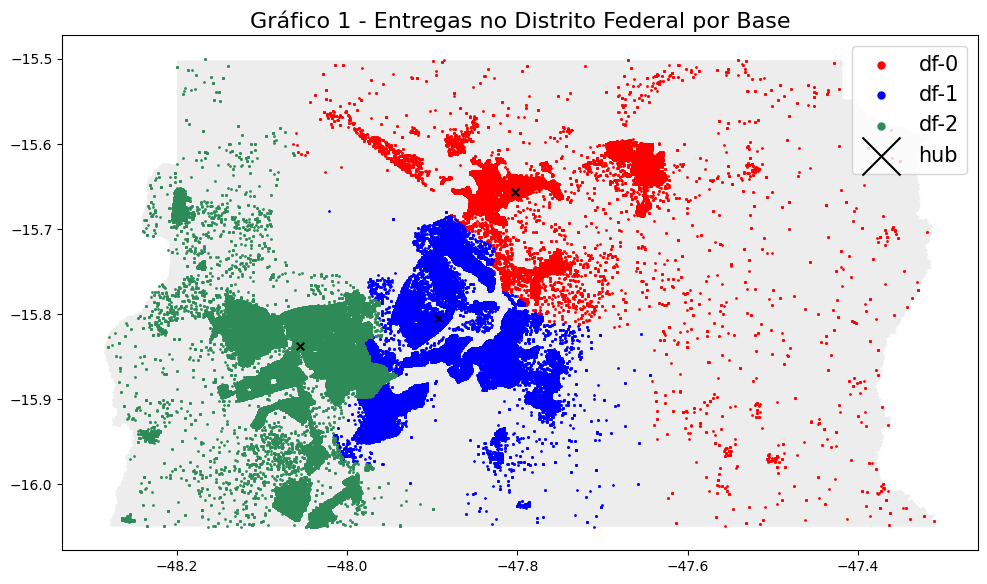

In [ ]:
mostrar_grafico_1()

**Insight** Gráfico 2 - Neste gráfico, podemos comparar o volume total de entregas em cada base. É perceptível que a base 'df-1' apresenta o maior volume de entregas, indicando um nível significativo de atividade de entregas nessa região. Essa observação sugere uma possível demanda elevada ou uma densidade populacional considerável nessa área. A base 'df-2' possui uma diferença relativamente pequena em relação à base 'df-1', o que sugere que ela provavelmente apresenta demanda semelhante à anterior. Por outro lado, notamos uma queda no volume na base 'df-0', o que pode ser explicado pela distribuição geográfica da área, como vimos no gráfico anterior, indicando que essa região está mais afastada do centro.

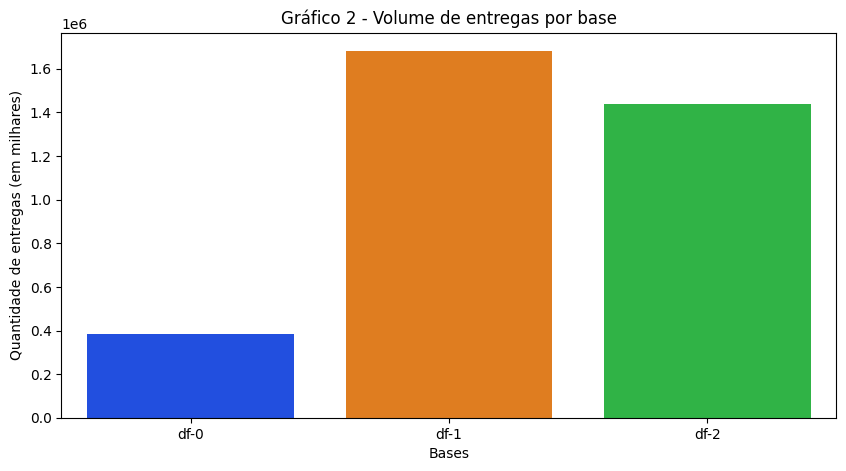

In [ ]:
mostrar_grafico_2()

**Insight** Gráfico 3 - Esse gráfico mostra a distribuição do tamanho médio das entregas. O uso desse tipo de gráfico nos permite visualizar a média, os quartis e a presença de valores atípicos. Notamos que o tamanho das entregas está em torno de 3 a 8, nunca ultrapassando o valor máximo, mas chegando perto dele, o que é considerado atípico. Com esses dados, percebemos que a empresa utiliza tamanhos variados, mas a maioria deles é relativamente uniforme, com exceção de algumas entregas que fogem desse padrão.

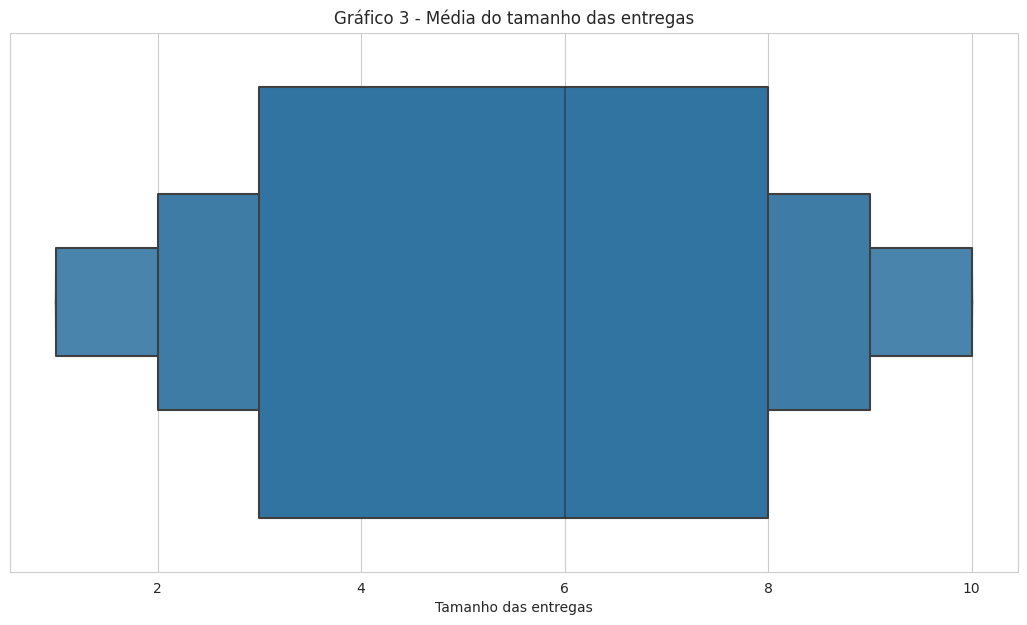

In [ ]:
mostrar_grafico_3()

**Insight** Gráfico 4 -  Nesse gráfico, identificamos as cidades com as maiores incidências de entregas no DF. Com essas informações, podemos ver em quais cidades se deve atualizar a rota de entregas ou até mesmo aumentar a quantidade de frotas para as entregas, observando a demanda de regiões e recalculando o número de entregas em outras regiões. Isso permite otimizar a logística de entregas, garantindo um melhor atendimento nas áreas com maior demanda.

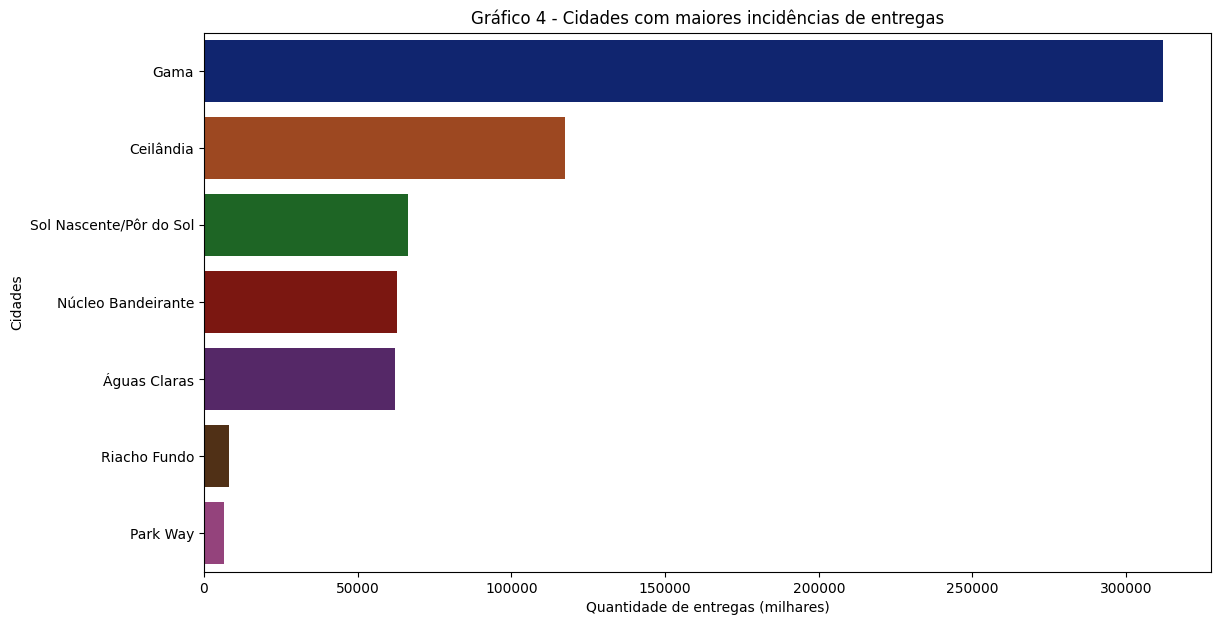

In [ ]:
mostrar_grafico_4()